In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from arch import arch_model
from scipy.optimize import minimize
import warnings

warnings.filterwarnings('ignore')


In [19]:
def load_market_cap_weights(filepath='Data/weights.xlsx', sheet_name='Sheet1'):
    """
    Load market capitalization weights from an Excel file, ensuring all 27 countries and groups are captured.

    Parameters:
    -----------
    filepath : str
        Path to the Excel file
    sheet_name : str
        Sheet name in the Excel file

    Returns:
    --------
    dict
        Dictionary with country codes as keys and their respective market cap weights
    dict
        Dictionary with region names as keys and their aggregated weights
    """
    df = pd.read_excel(filepath, sheet_name=sheet_name, header=None)

    # Define the six region groups as they appear in the file
    groups = ['WE', 'CEE', 'NE', 'SE', 'Most industrialized', 'Less industrialized']

    weights = {}  # Store country-level weights
    regional_weights = {region: {} for region in groups}  # Store region-level weights

    # Loop through pairs of columns with correct spacing (0-1, 3-4, 6-7, etc.)
    for col in range(0, df.shape[1], 3):  
        group_name = df.iloc[0, col]  # First row contains the region name

        if group_name in groups:
            for row in range(1, df.shape[0]):  # Read all rows under this region
                country = df.iloc[row, col]  # Country code
                weight = df.iloc[row, col + 1]  # Corresponding weight

                if pd.isna(country) or pd.isna(weight):  # Skip empty rows
                    continue
                
                # Convert weight from percentage to decimal
                weight = float(weight) 

                # Store country weights
                weights[country] = weight
                regional_weights[group_name][country] = weight  # Assign to correct region

    print(f"✅ Successfully loaded market cap weights for {len(weights)} countries across {len(groups)} regions.")
    
    # Extra debug check for missing regions
    for region, data in regional_weights.items():
        if not data:
            print(f"⚠️ Warning: Region '{region}' has no data. Double-check the Excel format.")

    return weights, regional_weights


In [20]:
weights, regional_weights = load_market_cap_weights()
print("\nCountry-level weights:", weights)
print("\nRegional weights:", regional_weights)


✅ Successfully loaded market cap weights for 25 countries across 6 regions.

Country-level weights: {'AT': 0.051995452604586274, 'BE': 0.15664998331625854, 'FR': 0.3703236785037146, 'DE': 0.3291252051365869, 'IE': 0.03456891499175773, 'LU': 0.007767041259047194, 'NL': 0.08698548087155158, 'BG': 0.003206475135558513, 'CZ': 0.011796338546853483, 'HR': 0.053609530393225274, 'HU': 0.010674507260670032, 'PL': 0.02374536036055713, 'RO': 0.010066963663812057, 'SI': 0.003616932700871001, 'DK': 0.18343151097417232, 'EE': 0.0014221443969054763, 'FI': 0.11524912492525843, 'LV': 0.00029175168170799786, 'LT': 0.0014223752605359203, 'SE': 0.3070697919591719, 'CY': 0.0007285647973653503, 'GR': 0.020174250257813477, 'IT': 0.08207895058113208, 'PT': 0.026258345874428775, 'ES': 0.10774132454645781}

Regional weights: {'WE': {'AT': 0.022697859997384207, 'BE': 0.06838327607117288, 'FR': 0.41929776426052295, 'DE': 0.3726509285961649, 'IE': 0.01509055798997283, 'LU': 0.00339058910463662, 'NL': 0.09848902398

In [21]:
def load_time_series_data(file_path, country_code):
    """
    Load time series data (energy and stock returns) for a given country.

    Parameters:
    -----------
    file_path : str
        Path to the Excel file
    country_code : str
        Country code (e.g., 'DE' for Germany)

    Returns:
    --------
    pd.DataFrame
        DataFrame with 'Date', 'Energy_Return', and 'Stock_Return' columns
    """
    try:
        # Load the country-specific sheet
        df = pd.read_excel(file_path, sheet_name=country_code, engine='openpyxl')

        # Extract the correct columns (5th, 6th, and 7th columns)
        df = df.iloc[:, [4, 5, 6]]  # Columns are indexed from 0
        df.columns = ['Date', 'Energy_Return', 'Stock_Return']

        # Convert date column to datetime format
        df['Date'] = pd.to_datetime(df['Date'])
        
        # Drop any rows with missing values
        df = df.dropna().set_index('Date')

        print(f"✅ Loaded {country_code}: {df.shape[0]} rows")

        return df

    except Exception as e:
        print(f"⚠️ Error loading data for {country_code}: {e}")
        return None


In [22]:
# Load data for Germany
gas_data = load_time_series_data('Data/Date input gas.xlsx', 'DE')
oil_data = load_time_series_data('Data/Date input oil.xlsx', 'DE')

# Display the first few rows
print("\n📊 Sample Data for Germany (Gas):")
print(gas_data.head())

print("\n📊 Sample Data for Germany (Oil):")
print(oil_data.head())


✅ Loaded DE: 3548 rows
✅ Loaded DE: 3552 rows

📊 Sample Data for Germany (Gas):
            Energy_Return  Stock_Return
Date                                   
2023-12-29      -0.023070      0.002995
2023-12-28      -0.070214     -0.002423
2023-12-27       0.038434      0.002146
2023-12-22      -0.000848      0.001124
2023-12-21       0.020141     -0.002731

📊 Sample Data for Germany (Oil):
            Energy_Return  Stock_Return
Date                                   
2023-12-29      -0.017372      0.002995
2023-12-28      -0.015946     -0.002423
2023-12-27       0.007309      0.002146
2023-12-22      -0.004039      0.001124
2023-12-21      -0.003897     -0.002731


In [23]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from arch import arch_model
import os
import warnings
from arch.utility.exceptions import ConvergenceWarning

# Suppress convergence warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

def fit_dcc_garch(returns1, returns2, max_attempts=3):
    if not isinstance(returns1, pd.Series):
        returns1 = pd.Series(returns1)
    if not isinstance(returns2, pd.Series):
        returns2 = pd.Series(returns2)

    returns1, returns2 = returns1.align(returns2, join='inner')

    returns_df = pd.DataFrame({
        'Asset1': returns1,
        'Asset2': returns2
    }).dropna()

    if len(returns_df) < 30:
        raise ValueError(f"Insufficient data points after cleaning: {len(returns_df)}. Need at least 30.")

    for attempt in range(max_attempts):
        try:
            model = DCC_GARCH(returns_df)
            model.fit_univariate_garch(retry_different_starting_values=(attempt > 0))

            starting_values = [
                [0.05, 0.85],
                [0.01, 0.97],
                [0.001, 0.9]
            ][attempt]

            print(f"DCC optimization attempt {attempt+1}/{max_attempts} with starting values {starting_values}")
            dcc_result = model.fit_dcc(starting_values=starting_values)

            if dcc_result['success']:
                correlations = model.get_conditional_correlations()
                smoothed_series = correlations.rolling(window=30, min_periods=10).mean()
                return smoothed_series
            else:
                print(f"DCC optimization did not converge: {dcc_result['message']}")
        except Exception as e:
            print(f"Attempt {attempt+1} failed: {str(e)}")

    try:
        print("Trying fallback with simpler DCC specification...")
        model = Simplified_DCC_GARCH(returns_df)
        model.fit()
        correlations = model.get_conditional_correlations()
        smoothed_series = correlations.rolling(window=30, min_periods=10).mean()
        print("Using simplified DCC model due to convergence issues")
        return smoothed_series
    except Exception as e:
        print(f"All attempts failed: {str(e)}")
        return None

class DCC_GARCH:
    def __init__(self, returns_df, p=1, q=1):
        self.returns = returns_df
        self.n_assets = returns_df.shape[1]
        self.asset_names = returns_df.columns
        self.T = returns_df.shape[0]
        self.p = p
        self.q = q
        self.univariate_results = {}
        self.std_residuals = pd.DataFrame(index=returns_df.index, columns=returns_df.columns)
        self.h_t = {}
        self.dcc_params = None
        self.R_bar = None
        self.Rt = None
        self.Qt = None

    def fit_univariate_garch(self, retry_different_starting_values=False):
        print("Fitting univariate GARCH models...")
        for asset in self.asset_names:
            print(f"Processing {asset}...")
            returns = self.returns[asset].values
            options = {}
            if retry_different_starting_values:
                options = {
                    'maxiter': 1000,
                    'ftol': 1e-10,
                }
            try:
                model = arch_model(returns, vol='GARCH', p=1, q=1, mean='Constant', rescale=True)
                result = model.fit(disp='off', options=options)
            except:
                model = arch_model(returns, vol='GARCH', p=1, q=1, mean='Constant')
                result = model.fit(disp='off', options=options)
            self.univariate_results[asset] = result
            self.std_residuals[asset] = result.resid / result.conditional_volatility
            self.h_t[asset] = result.conditional_volatility**2
        print("Univariate GARCH fitting completed.")
        return self.std_residuals

    def _dcc_likelihood(self, params):
        a, b = params
        if a <= 0 or b <= 0 or a + b >= 0.9999:
            return 1e10
        n = self.n_assets
        T = self.T
        eps = self.std_residuals.values
        Qt = np.zeros((T, n, n))
        Rt = np.zeros((T, n, n))
        Q_bar = np.corrcoef(eps.T)
        eigvals = np.linalg.eigvalsh(Q_bar)
        if np.min(eigvals) < 1e-10:
            Q_bar = Q_bar + np.eye(Q_bar.shape[0]) * (1e-8)
        Qt[0] = Q_bar.copy()
        q_diag = np.sqrt(np.diag(Qt[0]))
        Rt[0] = Qt[0] / np.outer(q_diag, q_diag)
        loglik = 0
        for t in range(1, T):
            Qt[t] = (1 - a - b) * Q_bar + a * np.outer(eps[t-1], eps[t-1]) + b * Qt[t-1]
            eigvals = np.linalg.eigvalsh(Qt[t])
            if np.min(eigvals) < 1e-10:
                Qt[t] = Qt[t] + np.eye(Qt[t].shape[0]) * (1e-8)
            q_diag = np.sqrt(np.diag(Qt[t]))
            Rt[t] = Qt[t] / np.outer(q_diag, q_diag)
            h_t_vector = np.array([np.sqrt(self.h_t[asset][t]) for asset in self.asset_names])
            Dt = np.diag(h_t_vector)
            Ht = Dt @ Rt[t] @ Dt
            try:
                log_det = np.log(np.linalg.det(Ht))
                inv_Ht = np.linalg.inv(Ht)
                quad_form = self.returns.iloc[t].values @ inv_Ht @ self.returns.iloc[t].values
                loglik += 0.5 * (log_det + quad_form)
            except:
                return 1e10
        self.Qt = Qt
        self.Rt = Rt
        self.R_bar = Q_bar
        return loglik

    def fit_dcc(self, starting_values=None):
        if starting_values is None:
            starting_values = [0.05, 0.90]
        print(f"Fitting DCC model using SQP optimization (Ox-Metrics compatible)...")
        print(f"Starting values: a={starting_values[0]:.4f}, b={starting_values[1]:.4f}")
        result = minimize(
            self._dcc_likelihood,
            starting_values,
            method='SLSQP',
            bounds=[(0.001, 0.3), (0.5, 0.999)],
            options={
                'disp': True,
                'maxiter': 10000,
                'ftol': 1e-10,
                'eps': 1e-10,
                'iprint': 1
            }
        )
        self.dcc_params = result.x
        _ = self._dcc_likelihood(self.dcc_params)
        print(f"DCC fitting completed. Parameters: a={self.dcc_params[0]:.6f}, b={self.dcc_params[1]:.6f}")
        return {
            'a': self.dcc_params[0],
            'b': self.dcc_params[1],
            'success': result.success,
            'message': result.message
        }

    def get_conditional_correlations(self):
        if self.Rt is None:
            raise ValueError("Model not yet fitted. Call fit_dcc() first.")
        i, j = 0, 1
        correlations = [self.Rt[t, i, j] for t in range(self.T)]
        return pd.Series(correlations, index=self.returns.index)

class Simplified_DCC_GARCH:
    def __init__(self, returns_df):
        self.returns = returns_df
        self.n_assets = returns_df.shape[1]
        self.asset_names = returns_df.columns
        self.T = returns_df.shape[0]
        self.std_resid = None
        self.Rt = None

    def fit(self):
        print("Fitting simplified DCC-GARCH model...")
        std_resid = pd.DataFrame(index=self.returns.index, columns=self.returns.columns)
        for col in self.returns.columns:
            model = arch_model(self.returns[col], vol='GARCH', p=1, q=1, rescale=True)
            res = model.fit(disp='off', options={'maxiter': 10000})
            std_resid[col] = res.resid / res.conditional_volatility
        self.std_resid = std_resid
        Q_bar = np.corrcoef(std_resid.values.T)
        a, b = 0.01, 0.90
        T = len(self.returns)
        Qt = np.zeros((T, self.n_assets, self.n_assets))
        Rt = np.zeros((T, self.n_assets, self.n_assets))
        Qt[0] = Q_bar.copy()
        q_diag = np.sqrt(np.diag(Qt[0]))
        Rt[0] = Qt[0] / np.outer(q_diag, q_diag)
        eps = std_resid.values
        for t in range(1, T):
            Qt[t] = (1 - a - b) * Q_bar + a * np.outer(eps[t-1], eps[t-1]) + b * Qt[t-1]
            eigvals = np.linalg.eigvalsh(Qt[t])
            if np.min(eigvals) < 1e-10:
                Qt[t] = Qt[t] + np.eye(self.n_assets) * 1e-6
            q_diag = np.sqrt(np.diag(Qt[t]))
            Rt[t] = Qt[t] / np.outer(q_diag, q_diag)
        self.Rt = Rt
        self.Q_bar = Q_bar
        print("Simplified DCC-GARCH model fitted.")
        return self

    def get_conditional_correlations(self):
        if self.Rt is None:
            raise ValueError("Model not fitted yet.")
        correlations = [self.Rt[t, 0, 1] for t in range(self.T)]
        return pd.Series(correlations, index=self.returns.index)

# load_time_series_data must be implemented by the user


✅ Loaded DE: 3548 rows
✅ Loaded DE: 3552 rows

🔥 Running DCC-GARCH for Germany (Gas vs Stock)...
Fitting univariate GARCH models...
Processing Asset1...
Processing Asset2...
Univariate GARCH fitting completed.
DCC optimization attempt 1/3 with starting values [0.05, 0.85]
Fitting DCC model using SQP optimization (Ox-Metrics compatible)...
Starting values: a=0.0500, b=0.8500
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4754.597899192245
            Iterations: 27
            Function evaluations: 130
            Gradient evaluations: 23
DCC fitting completed. Parameters: a=0.112553, b=0.887270
DCC optimization did not converge: Inequality constraints incompatible
Fitting univariate GARCH models...
Processing Asset1...
Processing Asset2...
Univariate GARCH fitting completed.
DCC optimization attempt 2/3 with starting values [0.01, 0.97]
Fitting DCC model using SQP optimization (Ox-Metrics compatible)...
Starting values: a=0.0100, b=0.9700
Opti

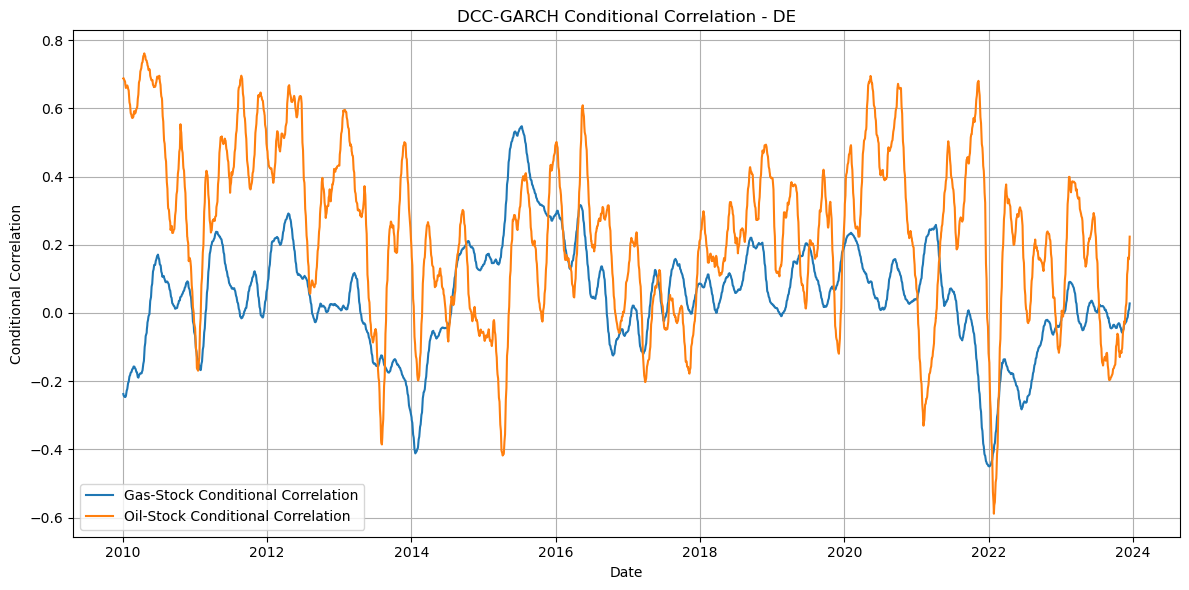

In [24]:
# Load data for Germany
gas_data = load_time_series_data('Data/Date input gas.xlsx', 'DE')
oil_data = load_time_series_data('Data/Date input oil.xlsx', 'DE')

# Ensure time alignment
common_dates = gas_data.index.intersection(oil_data.index)
gas_data, oil_data = gas_data.loc[common_dates], oil_data.loc[common_dates]
gas_data
# Fit DCC-GARCH for Gas-Stock
print("\n🔥 Running DCC-GARCH for Germany (Gas vs Stock)...")
gas_stock_corr = fit_dcc_garch(gas_data['Energy_Return'], gas_data['Stock_Return'])

# Fit DCC-GARCH for Oil-Stock
print("\n🔥 Running DCC-GARCH for Germany (Oil vs Stock)...")
oil_stock_corr = fit_dcc_garch(oil_data['Energy_Return'], oil_data['Stock_Return'])

# Plot results
plt.figure(figsize=(12,6))
plt.plot(common_dates, gas_stock_corr, label='Gas-Stock Conditional Correlation')
plt.plot(common_dates, oil_stock_corr, label='Oil-Stock Conditional Correlation')
plt.title(f'DCC-GARCH Conditional Correlation - DE')
plt.xlabel('Date')
plt.ylabel('Conditional Correlation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
events = [
    (pd.Timestamp('2014-03-01'), 'Crimea Annexation', '^'),
    (pd.Timestamp('2020-03-01'), 'COVID-19', 's'),
    (pd.Timestamp('2022-02-24'), 'Ukraine War', 'o')
]


In [26]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from arch import arch_model
import os
import warnings
import matplotlib.pyplot as plt
from arch.utility.exceptions import ConvergenceWarning

import numpy as np
import pandas as pd
from scipy.optimize import minimize
from arch import arch_model
import os
import warnings
import matplotlib.pyplot as plt
from arch.utility.exceptions import ConvergenceWarning

# Suppress convergence warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

def plot_correlation(correlation_series, title, region=None, events=None, filename=None):
    """
    Plot DCC-GARCH correlation for one region and save as transparent PNG.

    Parameters:
    -----------
    correlation_series : pd.Series
        Time-varying correlation series
    title : str
        Title of the plot
    region : str
        Region label for color (optional)
    events : list of (datetime, str, str)
        List of (date, label, marker) tuples
    filename : str
        Path to save PNG (transparent)
    """
    if correlation_series is None or correlation_series.empty:
        print(f"⚠️ No data for region: {region}")
        return

    # Set up color palette
    region_colors = {
        'WE': '#1f77b4', 'CEE': '#2ca02c', 'NE': '#ff7f0e',
        'SE': '#9467bd', 'Most industrialized': '#d62728', 'Less industrialized': '#17becf'
    }

    color = region_colors.get(region, '#003366')

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(correlation_series.index, correlation_series.values, linewidth=1.5, color=color)

    plt.axhline(0, linestyle='--', color='gray', linewidth=0.8)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Snap event markers to nearest date in index
    if events:
        for date, label, marker in events:
            try:
                idx = correlation_series.index.get_indexer([date], method='nearest')[0]
                nearest_date = correlation_series.index[idx]
                y = correlation_series.iloc[idx]

                plt.scatter(nearest_date, y, marker=marker, s=120, color='red', edgecolor='black', linewidths=1.2, zorder=6)
                plt.annotate(label, (nearest_date, y),
                             xytext=(0, 15), textcoords='offset points', fontsize=10, ha='center',
                             arrowprops=dict(arrowstyle='->', color='black'),
                             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.8))
            except Exception as e:
                print(f"⚠️ Couldn't mark event '{label}' on {date.date()}: {e}")

    # Remove top/right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Save as transparent PNG
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight', transparent=True)
        print(f"✅ Saved: {filename}")

    plt.close()





def run_dcc_analysis(countries, energy_type='OIL', data_path='Data', events=None):
    """
    Run DCC-GARCH analysis for a list of countries and a given energy type.
    Parameters:
    -----------
    countries : list of str
        List of country codes
    energy_type : str
        'OIL' or 'GAS'
    data_path : str
        Path to the folder with Excel files
    events : list of (pd.Timestamp, str, str)
        Optional list of event tuples (date, label, marker)
    Returns:
    --------
    dict
        Dictionary with country code as key and conditional correlation Series as value
    """
    filename = f"{data_path}/Date input oil.xlsx" if energy_type == 'OIL' else f"{data_path}/Date input gas.xlsx"
    correlation_results = {}

    output_dir = f"Outputs/{energy_type.lower()}_correlations"
    os.makedirs(output_dir, exist_ok=True)

    for country in countries:
        print(f"\n📊 Processing {country} - {energy_type}...")
        df = load_time_series_data(filename, country)
        if df is None or df.empty:
            print(f"⚠️ Skipping {country} due to missing data.")
            continue

        print(f"Columns available: {df.columns.tolist()}")

        energy_col = None
        stock_col = None

        for col in df.columns:
            if 'energy' in col.lower() or energy_type.lower() in col.lower():
                energy_col = col
                break

        for col in df.columns:
            if 'stock' in col.lower() or 'index' in col.lower() or 'market' in col.lower():
                stock_col = col
                break

        if energy_col is None and len(df.columns) > 0:
            energy_col = df.columns[0]
            print(f"Could not identify energy column. Using first column: {energy_col}")

        if stock_col is None and len(df.columns) > 1:
            stock_col = df.columns[1]
            print(f"Could not identify stock column. Using second column: {stock_col}")
        elif stock_col is None and len(df.columns) == 1:
            print(f"⚠️ Skipping {country} due to insufficient columns (need at least 2).")
            continue

        if energy_col is None or stock_col is None:
            print(f"⚠️ Skipping {country} due to missing required columns.")
            continue

        print(f"Using columns: Energy = {energy_col}, Stock = {stock_col}")

        try:
            correlation = fit_dcc_garch(df[energy_col], df[stock_col])

            if correlation is not None and not correlation.empty:
                correlation_results[country] = correlation
                csv_file = f"{output_dir}/{country}_{energy_type.lower()}_correlation.csv"
                correlation.to_csv(csv_file)

                # Plot with events and transparent background
                chart_file = f"{output_dir}/{country}_{energy_type.lower()}_correlation.png"
                plot_correlation(
                    correlation_series=correlation,
                    title=f"{country} - {energy_type} vs Stock Market Conditional Correlation",
                    region=country,
                    events=events,
                    filename=chart_file
                )
            else:
                print(f"❌ DCC-GARCH produced empty results for {country}")
        except Exception as e:
            print(f"❌ DCC-GARCH failed for {country}: {str(e)}")

    return correlation_results

# Example usage:
# events = [
#     (pd.Timestamp('2014-03-01'), 'Crimea Annexation', '^'),
#     (pd.Timestamp('2020-03-01'), 'COVID-19', 's'),
#     (pd.Timestamp('2022-02-24'), 'Ukraine War', 'o')
# ]
# run_dcc_analysis(countries=['DE', 'FR', 'RO'], energy_type='OIL', data_path='Data', events=events)


In [27]:
countries = [
    'AT', 'BE', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 
    'DE', 'GR', 'HU', 'IE', 'IT', 'LV', 'LT', 'LU', 'MT', 'NL', 
    'PL', 'PT', 'RO', 'SK', 'SI', 'ES', 'SE'
]


In [28]:
# Run for Oil
print("\n🚀 Running DCC-GARCH for OIL across 27 countries...")
oil_correlations = run_dcc_analysis(countries, energy_type='OIL', data_path='Data', events=events)

# Run for Gas
print("\n🚀 Running DCC-GARCH for GAS across 27 countries...")
gas_correlations = run_dcc_analysis(countries, energy_type='GAS', data_path='Data', events=events)



🚀 Running DCC-GARCH for OIL across 27 countries...

📊 Processing AT - OIL...
✅ Loaded AT: 3495 rows
Columns available: ['Energy_Return', 'Stock_Return']
Using columns: Energy = Energy_Return, Stock = Stock_Return
Fitting univariate GARCH models...
Processing Asset1...
Processing Asset2...
Univariate GARCH fitting completed.
DCC optimization attempt 1/3 with starting values [0.05, 0.85]
Fitting DCC model using SQP optimization (Ox-Metrics compatible)...
Starting values: a=0.0500, b=0.8500
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2527.0520843524664
            Iterations: 25
            Function evaluations: 122
            Gradient evaluations: 21
DCC fitting completed. Parameters: a=0.112656, b=0.887228
✅ Saved: Outputs/oil_correlations/AT_oil_correlation.png

📊 Processing BE - OIL...
✅ Loaded BE: 3583 rows
Columns available: ['Energy_Return', 'Stock_Return']
Using columns: Energy = Energy_Return, Stock = Stock_Return
Fitting univariate

/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Optimization terminated successfully    (Exit mode 0)
            Current function value: -4617.998827099834
            Iterations: 28
            Function evaluations: 186
            Gradient evaluations: 26
DCC fitting completed. Parameters: a=0.112614, b=0.887286
✅ Saved: Outputs/gas_correlations/DE_gas_correlation.png

📊 Processing GR - GAS...
✅ Loaded GR: 3452 rows
Columns available: ['Energy_Return', 'Stock_Return']
Using columns: Energy = Energy_Return, Stock = Stock_Return
Fitting univariate GARCH models...
Processing Asset1...
Processing Asset2...
Univariate GARCH fitting completed.
DCC optimization attempt 1/3 with starting values [0.05, 0.85]
Fitting DCC model using SQP optimization (Ox-Metrics compatible)...
Starting values: a=0.0500, b=0.8500
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3104.076650544537
            Iterations: 25
            Function evaluations: 113
            Gradient evaluations: 21
DCC fitting completed

/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Optimization terminated successfully    (Exit mode 0)
            Current function value: -4429.565020559357
            Iterations: 23
            Function evaluations: 101
            Gradient evaluations: 19
DCC fitting completed. Parameters: a=0.112559, b=0.887161
✅ Saved: Outputs/gas_correlations/ES_gas_correlation.png

📊 Processing SE - GAS...
✅ Loaded SE: 3514 rows
Columns available: ['Energy_Return', 'Stock_Return']
Using columns: Energy = Energy_Return, Stock = Stock_Return
Fitting univariate GARCH models...
Processing Asset1...
Processing Asset2...
Univariate GARCH fitting completed.
DCC optimization attempt 1/3 with starting values [0.05, 0.85]
Fitting DCC model using SQP optimization (Ox-Metrics compatible)...
Starting values: a=0.0500, b=0.8500


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Optimization terminated successfully    (Exit mode 0)
            Current function value: -4841.430087847491
            Iterations: 22
            Function evaluations: 106
            Gradient evaluations: 18
DCC fitting completed. Parameters: a=0.112622, b=0.887276
✅ Saved: Outputs/gas_correlations/SE_gas_correlation.png


In [29]:
def aggregate_correlations_by_region(country_correlations, regional_weights):
    """
    Aggregate country-level correlation series into region-level series using market cap weights.

    Parameters:
    -----------
    country_correlations : dict
        Country-level DCC-GARCH correlations {country: pd.Series}
    regional_weights : dict
        Market cap weights by region {region: {country: weight}}

    Returns:
    --------
    dict
        Region-level correlation series {region: pd.Series}
    """
    print("\n📦 Aggregating correlations by region...")

    # Build master date index
    all_dates = sorted(set().union(*(series.index for series in country_correlations.values())))
    combined_df = pd.DataFrame(index=all_dates)

    # Add each country's correlation to the DataFrame
    for country, series in country_correlations.items():
        combined_df[country] = series

    regional_correlations = {}

    for region, country_weights in regional_weights.items():
        if not country_weights:
            print(f"⚠️ Skipping region {region} — no country weights found.")
            continue

        print(f"🧭 Aggregating region: {region} ({len(country_weights)} countries)")

        # Initialize weighted sum series
        weighted_corr = pd.Series(0.0, index=combined_df.index)

        for country, weight in country_weights.items():
            if country in combined_df.columns:
                weighted_corr += combined_df[country].fillna(0) * weight
            else:
                print(f"   ⚠️ Missing country data for: {country}")

        regional_correlations[region] = weighted_corr

        print(f"   ✅ {region}: Aggregated {weighted_corr.count()} non-NA values")

    return regional_correlations


In [30]:
# Aggregate OIL correlations
regional_oil_corr = aggregate_correlations_by_region(oil_correlations, regional_weights)

# Aggregate GAS correlations
regional_gas_corr = aggregate_correlations_by_region(gas_correlations, regional_weights)



📦 Aggregating correlations by region...
🧭 Aggregating region: WE (7 countries)
   ✅ WE: Aggregated 3605 non-NA values
🧭 Aggregating region: CEE (7 countries)
   ✅ CEE: Aggregated 3605 non-NA values
🧭 Aggregating region: NE (6 countries)
   ✅ NE: Aggregated 3605 non-NA values
🧭 Aggregating region: SE (5 countries)
   ✅ SE: Aggregated 3605 non-NA values
🧭 Aggregating region: Most industrialized (6 countries)
   ✅ Most industrialized: Aggregated 3605 non-NA values
🧭 Aggregating region: Less industrialized (19 countries)
   ✅ Less industrialized: Aggregated 3605 non-NA values

📦 Aggregating correlations by region...
🧭 Aggregating region: WE (7 countries)
   ✅ WE: Aggregated 3591 non-NA values
🧭 Aggregating region: CEE (7 countries)
   ✅ CEE: Aggregated 3591 non-NA values
🧭 Aggregating region: NE (6 countries)
   ✅ NE: Aggregated 3591 non-NA values
🧭 Aggregating region: SE (5 countries)
   ✅ SE: Aggregated 3591 non-NA values
🧭 Aggregating region: Most industrialized (6 countries)
   ✅ Most

In [31]:
def plot_correlation(correlation_series, title, region=None, events=None, filename=None):
    """
    Plot DCC-GARCH correlation for one region and save as transparent PNG.

    Parameters:
    -----------
    correlation_series : pd.Series
        Time-varying correlation series
    title : str
        Title of the plot
    region : str
        Region label for color (optional)
    events : list of (datetime, str, str)
        List of (date, label, marker) tuples
    filename : str
        Path to save PNG (transparent)
    """
    if correlation_series is None or correlation_series.empty:
        print(f"⚠️ No data for region: {region}")
        return

    # Set up color palette
    region_colors = {
        'WE': '#1f77b4', 'CEE': '#2ca02c', 'NE': '#ff7f0e',
        'SE': '#9467bd', 'Most industrialized': '#d62728', 'Less industrialized': '#17becf'
    }

    color = region_colors.get(region, '#003366')

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(correlation_series.index, correlation_series.values, linewidth=1.5, color=color)

    plt.axhline(0, linestyle='--', color='gray', linewidth=0.8)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Snap event markers to nearest date in index
    if events:
        for date, label, marker in events:
            try:
                idx = correlation_series.index.get_indexer([date], method='nearest')[0]
                nearest_date = correlation_series.index[idx]
                y = correlation_series.iloc[idx]

                plt.scatter(nearest_date, y, marker=marker, s=60, color='red', zorder=5)
                plt.annotate(label, (nearest_date, y),
                             xytext=(10, 10), textcoords='offset points',
                             fontsize=9, backgroundcolor='none',
                             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
            except Exception as e:
                print(f"⚠️ Couldn't mark event '{label}' on {date.date()}: {e}")

    # Remove top/right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Save as transparent PNG
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight', transparent=True)
        print(f"✅ Saved: {filename}")

    plt.close()

In [32]:
# OIL plots with events
for region, series in regional_oil_corr.items():
    plot_correlation(
        correlation_series=series,
        title=f"{region} vs Oil - Conditional Correlation",
        region=region,
        events=events,
        filename=f"Outputs/Plots/{region}_oil_corr.png"
    )

# GAS plots with events
for region, series in regional_gas_corr.items():
    plot_correlation(
        correlation_series=series,
        title=f"{region} vs Gas - Conditional Correlation",
        region=region,
        events=events,
        filename=f"Outputs/Plots/{region}_gas_corr.png"
    )


✅ Saved: Outputs/Plots/WE_oil_corr.png
✅ Saved: Outputs/Plots/CEE_oil_corr.png
✅ Saved: Outputs/Plots/NE_oil_corr.png
✅ Saved: Outputs/Plots/SE_oil_corr.png
✅ Saved: Outputs/Plots/Most industrialized_oil_corr.png
✅ Saved: Outputs/Plots/Less industrialized_oil_corr.png
✅ Saved: Outputs/Plots/WE_gas_corr.png
✅ Saved: Outputs/Plots/CEE_gas_corr.png
✅ Saved: Outputs/Plots/NE_gas_corr.png
✅ Saved: Outputs/Plots/SE_gas_corr.png
✅ Saved: Outputs/Plots/Most industrialized_gas_corr.png
✅ Saved: Outputs/Plots/Less industrialized_gas_corr.png
